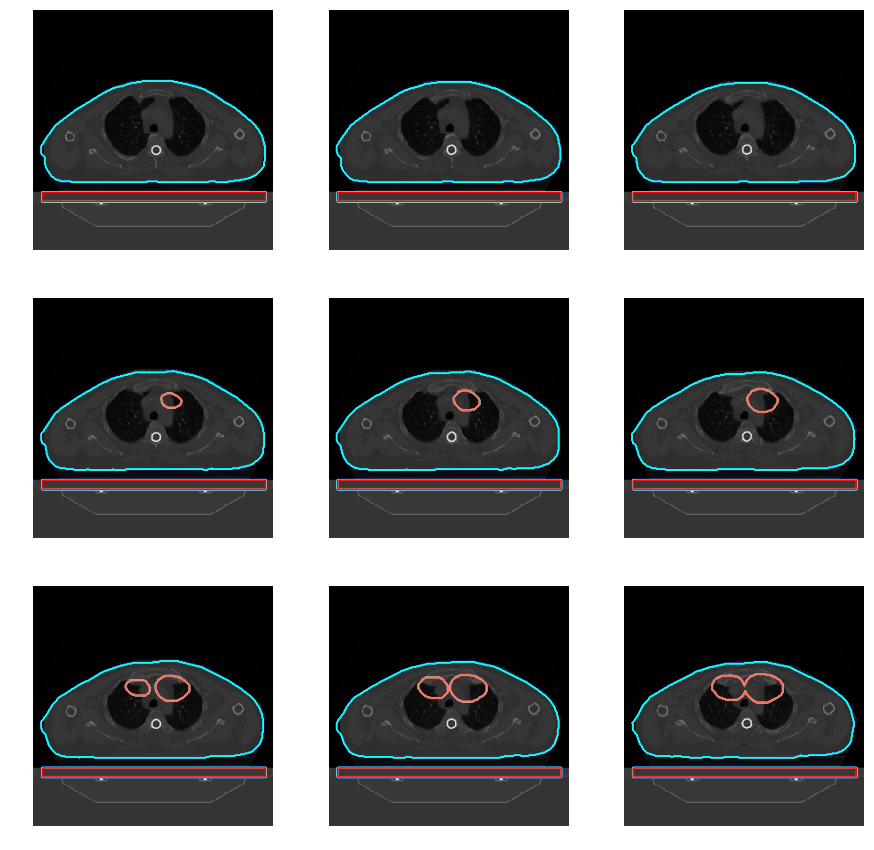

In [44]:
import os, sys, glob
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.draw import polygon
import nibabel as nib

def read_structure(structure):
    """
    INPUT:
        structure: RTSS structure file
    OUTPUT:
        contours: a list of structures, where each structure is a dict with structure name, color, number & coordinates
    """
    contours = []
    for i in range(len(structure.ROIContourSequence)):
        contour = {}
        contour['color'] = structure.ROIContourSequence[i].ROIDisplayColor
        # contour['number'] = structure.ROIContourSequence[i].RefdROINumber
        contour['number'] = structure.StructureSetROISequence[i].ROINumber
        contour['name'] = structure.StructureSetROISequence[i].ROIName
        # assert contour['number'] == structure.StructureSetROISequence[i].ROINumber
        contour['contours'] = [s.ContourData for s in structure.ROIContourSequence[i].ContourSequence]
        contours.append(contour)
    return contours

def get_mask(contours, slices):
    """
    INPUT:
        coutours: output from read_structure; a list of structures
        slices: a list of dicom slices of CT scan corresponding to contours
    OUTPUT:
        label: a mask of the original CT scan where the values correspond to structure number
        colors: a list of colors corresponding 
    """
    z = [s.ImagePositionPatient[2] for s in slices]
    pos_r = slices[0].ImagePositionPatient[1]
    spacing_r = slices[0].PixelSpacing[1]
    pos_c = slices[0].ImagePositionPatient[0]
    spacing_c = slices[0].PixelSpacing[0]

    label = np.zeros_like(image, dtype=np.uint8)
    for con in contours:
        num = int(con['number'])
        for c in con['contours']:
            nodes = np.array(c).reshape((-1, 3))
            assert np.amax(np.abs(np.diff(nodes[:, 2]))) == 0
            zNew = [round(elem,1) for elem in z ] 
            try:
                z_index = z.index(nodes[0, 2])
            except ValueError:
                z_index = zNew.index(nodes[0, 2])
            # z_index = z.index(np.around(nodes[0, 2],1))
            r = (nodes[:, 1] - pos_r) / spacing_r
            c = (nodes[:, 0] - pos_c) / spacing_c
            rr, cc = polygon(r, c)
            label[rr, cc, z_index] = num
    colors = tuple(np.array([con['color'] for con in contours]) / 255.0)
    return label, colors

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices], axis=-1)
    # Convert to int16 (from sometimes int16),
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0

    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)

In [45]:
train_data_path = "./data/Head-Neck-PET-CT"
train_patients = [os.path.join(train_data_path, name) for name in os.listdir(train_data_path) if os.path.isdir(os.path.join(train_data_path, name))]
patient = train_patients[0] # Just get the first patient for demo

#walk in patient directory for DICOM slices of CT, and RTSS
for subdir, dirs, files in os.walk(patient):
    dcms = glob.glob(os.path.join(subdir, "*.dcm"))
    if len(dcms) == 1:
        structure = dicom.read_file(os.path.join(subdir, files[0]))
        contours = read_structure(structure)
    elif len(dcms) > 1:
        slices = [dicom.read_file(dcm) for dcm in dcms]
        slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
        image = np.stack([s.pixel_array for s in slices], axis=-1)
label, colors = get_mask(contours, slices)

#convert to hounsfeld unit
image = get_pixels_hu(slices)

# Plot to check slices, for example 50 to 59
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[..., i + 30], cmap="gray")
    plt.contour(label[..., i + 30], colors=colors)
    plt.axis('off')
    
label_nii = nib.Nifti1Image(label, np.eye(4))
image_nii = nib.Nifti1Image(image, np.eye(4))
label_nii.to_filename('label.nii')
image_nii.to_filename('image.nii')